This is the Group 9 Project Report ipynb File!

In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

In [2]:
url <- "https://raw.githubusercontent.com/EPICxFLIPPER/data/main/OnlineNewsPopularity.csv"
popularity <- read_csv(url)
head(popularity)

Rows: 39644 Columns: 61
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): url
dbl (60): timedelta, n_tokens_title, n_tokens_content, n_unique_tokens, n_no...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,⋯,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
http://mashable.com/2013/01/07/amazon-instant-video-browser/,731,12,219,0.6635945,1,0.8153846,4,2,1,⋯,0.10000000,0.7,-0.3500000,-0.600,-0.2000000,0.5000000,-0.1875000,0.00000000,0.1875000,593
http://mashable.com/2013/01/07/ap-samsung-sponsored-tweets/,731,9,255,0.6047431,1,0.7919463,3,1,1,⋯,0.03333333,0.7,-0.1187500,-0.125,-0.1000000,0.0000000,0.0000000,0.50000000,0.0000000,711
http://mashable.com/2013/01/07/apple-40-billion-app-downloads/,731,9,211,0.5751295,1,0.6638655,3,1,1,⋯,0.10000000,1.0,-0.4666667,-0.800,-0.1333333,0.0000000,0.0000000,0.50000000,0.0000000,1500
http://mashable.com/2013/01/07/astronaut-notre-dame-bcs/,731,9,531,0.5037879,1,0.6656347,9,0,1,⋯,0.13636364,0.8,-0.3696970,-0.600,-0.1666667,0.0000000,0.0000000,0.50000000,0.0000000,1200
http://mashable.com/2013/01/07/att-u-verse-apps/,731,13,1072,0.4156456,1,0.5408895,19,19,20,⋯,0.03333333,1.0,-0.2201923,-0.500,-0.0500000,0.4545455,0.1363636,0.04545455,0.1363636,505
http://mashable.com/2013/01/07/beewi-smart-toys/,731,10,370,0.5598886,1,0.6981982,2,2,0,⋯,0.13636364,0.6,-0.1950000,-0.400,-0.1000000,0.6428571,0.2142857,0.14285714,0.2142857,855


In [3]:
set.seed(9)
#Wrangling
popularity_tidy <- popularity |> 
#removing columns that are specifically not litsted as predictors as well as columns that self reference articles.
select(-url, -timedelta , - num_self_hrefs, -self_reference_min_shares:-self_reference_avg_sharess,
      -is_weekend, -kw_min_min:-kw_avg_avg, -LDA_00:-LDA_04, -global_subjectivity:-abs_title_sentiment_polarity,
      -n_non_stop_words,-n_non_stop_unique_tokens, -data_channel_is_lifestyle:-weekday_is_sunday, -num_keywords) 


glimpse(popularity_tidy)

Rows: 39,644
Columns: 8
$ n_tokens_title       <dbl> 12, 9, 9, 9, 13, 10, 8, 12, 11, 10, 9, 10, 9, 9, …
$ n_tokens_content     <dbl> 219, 255, 211, 531, 1072, 370, 960, 989, 97, 231,…
$ n_unique_tokens      <dbl> 0.6635945, 0.6047431, 0.5751295, 0.5037879, 0.415…
$ num_hrefs            <dbl> 4, 3, 3, 9, 19, 2, 21, 20, 2, 4, 11, 7, 18, 4, 19…
$ num_imgs             <dbl> 1, 1, 1, 1, 20, 0, 20, 20, 0, 1, 1, 1, 11, 0, 9, …
$ num_videos           <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 21, 0, 0, …
$ average_token_length <dbl> 4.680365, 4.913725, 4.393365, 4.404896, 4.682836,…
$ shares               <dbl> 593, 711, 1500, 1200, 505, 855, 556, 891, 3600, 7…


In [4]:
set.seed(9)
#Splitting the data into training and testing data
#Strata = the day the article was published
popularity_split<- initial_split(popularity_tidy, prop = .75, strata = shares)
popularity_train<- training(popularity_split)
popularity_test <- testing(popularity_split)


In [5]:
set.seed(9)
initial_table <- popularity_train |>
map_df(mean, na.rm =TRUE)
initial_table

n_tokens_title,n_tokens_content,n_unique_tokens,num_hrefs,num_imgs,num_videos,average_token_length,shares
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10.39271,545.4947,0.5542134,10.85356,4.50898,1.251816,4.547672,3380.916


Warning message:
“Removed 325 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


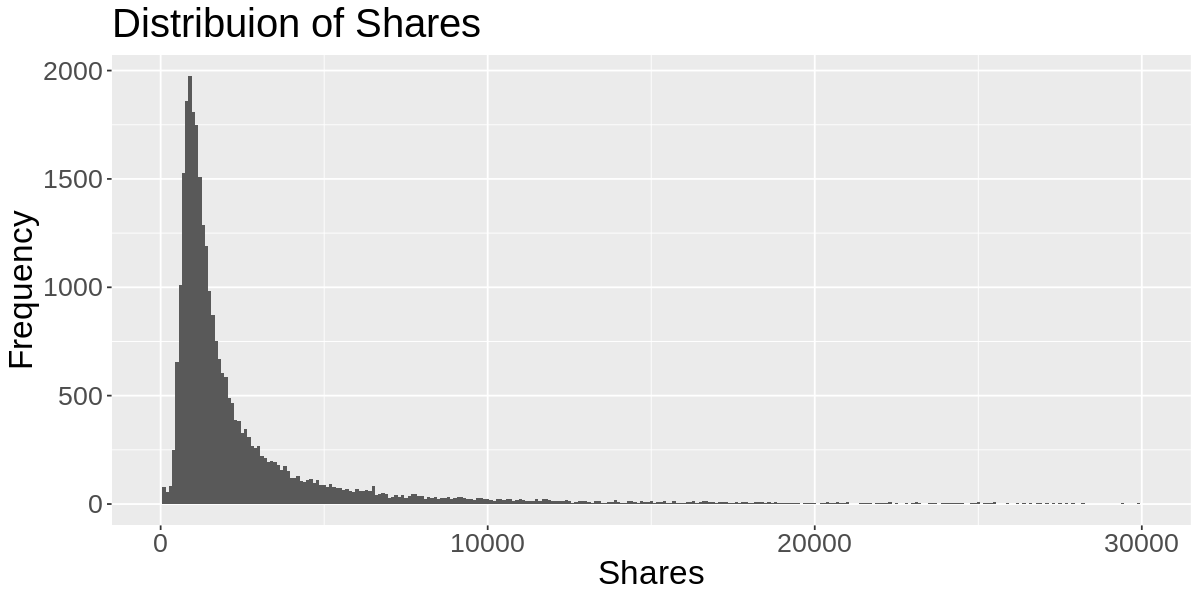

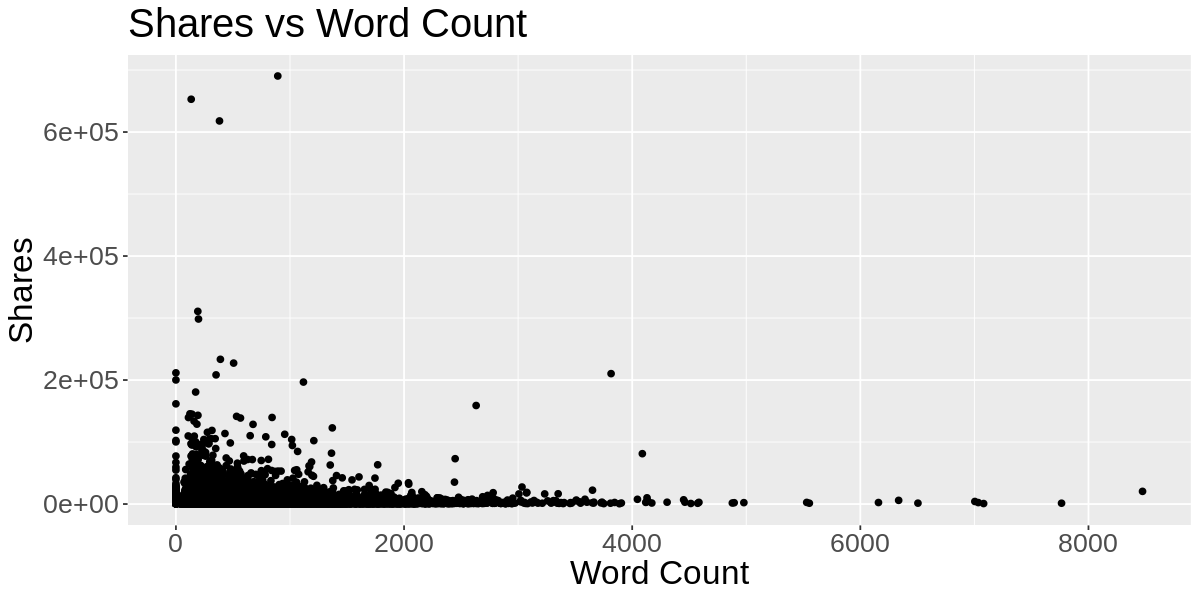

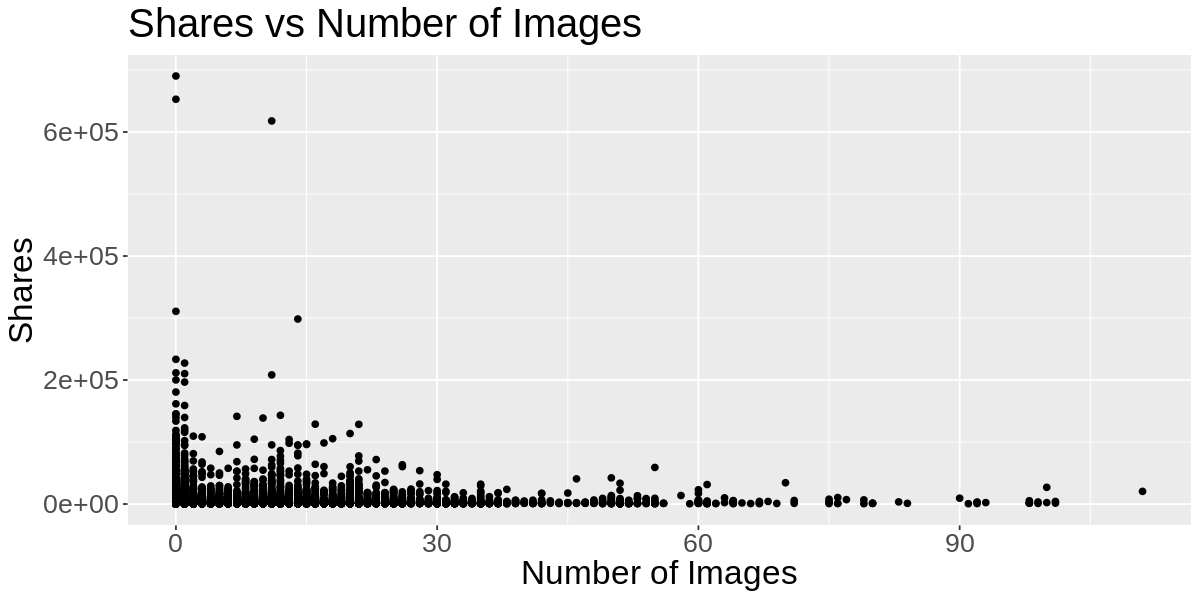

In [6]:
set.seed(9)
#Below are the distributions of the 3 most varable categoreis in our data set. Though some of the categories are less variable, we belive 
#they will still be good predictors of shares.

options(repr.plot.width = 10, repr.plot.height =5)

shares_plot <- popularity_train |> 
ggplot(aes(x = shares)) + geom_histogram(binwidth = 100)+xlim(0,30000) +labs(x = "Shares" , y = "Frequency") +
ggtitle("Distribuion of Shares") + theme(text = element_text(size = 20))

shares_vs_word_count_plot <- popularity_train |>
ggplot(aes(x = n_tokens_content , y = shares)) + geom_point() + xlab("Word Count") + ylab("Shares") + ggtitle("Shares vs Word Count") +
theme(text = element_text(size = 20))

shares_vs_images_plot <- popularity_train |>
ggplot(aes(x = num_imgs , y = shares)) + geom_point() + xlab("Number of Images") + ylab("Shares") + ggtitle("Shares vs Number of Images") +
theme(text = element_text(size = 20))



shares_plot
shares_vs_word_count_plot
shares_vs_images_plot